<a href="https://colab.research.google.com/github/jncraton/brick-classifier/blob/main/brick_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

cuda:0


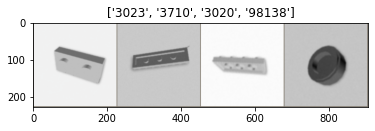

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        #transforms.RandomRotation(45),
        transforms.RandomResizedCrop(224, scale=(0.7,1.3), ratio=(1.0,1.0)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        #transforms.RandomRotation(45),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/MyDrive/lego-parts'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [3]:
import json

json.dumps(class_names)

'["3004", "3005", "3020", "3023", "3024", "3069b", "3710", "54200", "6141", "98138"]'

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [5]:
feature_extractor_only = True

#model = models.resnet18(pretrained=True)

model = models.squeezenet1_1(pretrained=True)

criterion = nn.CrossEntropyLoss()

if feature_extractor_only:
  for param in model.parameters():
      param.requires_grad = False

# Swap with below for resnet18
#num_ftrs = model.fc.in_features
#model.fc = nn.Linear(num_ftrs, len(class_names))

model.classifier = nn.Sequential (
    nn.Dropout(0.1),
    nn.Conv2d(512, len(class_names), kernel_size= (1,1), stride= (1,1)),
    nn.ReLU(), 
    nn.AvgPool2d(kernel_size= 13, stride= 1, padding= 0)
    )
model.num_classes = len(class_names)

model = model.to(device)

# Parameters of newly constructed modules have requires_grad=True by default
# Observe that only parameters of final layer are being optimized as
# opposed to before.
#optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer, exp_lr_scheduler,
                      num_epochs=25)

Downloading: "https://download.pytorch.org/models/squeezenet1_1-f364aa15.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-f364aa15.pth



Epoch 0/24
----------
train Loss: 1.5636 Acc: 0.4370
val Loss: 1.0235 Acc: 0.6111

Epoch 1/24
----------
train Loss: 0.8295 Acc: 0.7074
val Loss: 0.8161 Acc: 0.7222

Epoch 2/24
----------
train Loss: 0.6347 Acc: 0.7691
val Loss: 0.5768 Acc: 0.8000

Epoch 3/24
----------
train Loss: 0.5453 Acc: 0.8025
val Loss: 0.5640 Acc: 0.7444

Epoch 4/24
----------
train Loss: 0.4341 Acc: 0.8444
val Loss: 0.5210 Acc: 0.8222

Epoch 5/24
----------
train Loss: 0.3963 Acc: 0.8679
val Loss: 0.4610 Acc: 0.8444

Epoch 6/24
----------
train Loss: 0.3645 Acc: 0.8704
val Loss: 0.4794 Acc: 0.8778

Epoch 7/24
----------
train Loss: 0.2728 Acc: 0.9346
val Loss: 0.4211 Acc: 0.8444

Epoch 8/24
----------
train Loss: 0.2671 Acc: 0.9469
val Loss: 0.4275 Acc: 0.8333

Epoch 9/24
----------
train Loss: 0.2530 Acc: 0.9432
val Loss: 0.4176 Acc: 0.8333

Epoch 10/24
----------
train Loss: 0.2444 Acc: 0.9420
val Loss: 0.4151 Acc: 0.8333

Epoch 11/24
----------
train Loss: 0.2556 Acc: 0.9346
val Loss: 0.4259 Acc: 0.8333

E

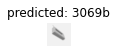

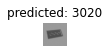

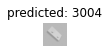

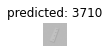

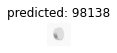

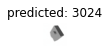

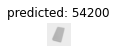

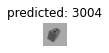

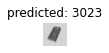

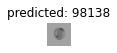

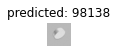

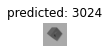

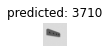

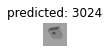

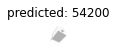

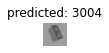

In [6]:
visualize_model(model, num_images=6)

In [7]:
import torch.onnx

batch_size = 1

cpu_model = model.to('cpu')

# Input to the model
x = torch.randn(batch_size, 3, 224, 224, requires_grad=True)
output = cpu_model(x)

# Export the model
torch.onnx.export(cpu_model,               # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  "part-classifier.onnx",    # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=9,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                'output' : {0 : 'batch_size'}})


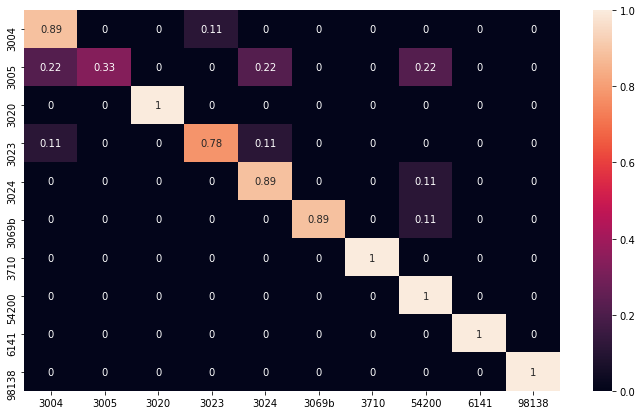

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in dataloaders['val']:
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = class_names,
                     columns = class_names)
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')